In [1]:
import sys
import datetime
import tempfile
import re
import math
import json
import easyocr
import cv2
from PIL import Image
import imutils
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from pytesseract import Output

In [2]:
cv2.__version__

'4.5.4'

In [3]:
pytesseract.get_tesseract_version() 
# pytesseract.__version__

<Version('4.1.1')>

In [4]:
image_path = '../output/수입면장-FAX-img0.jpg'

Do not find rectangle contour


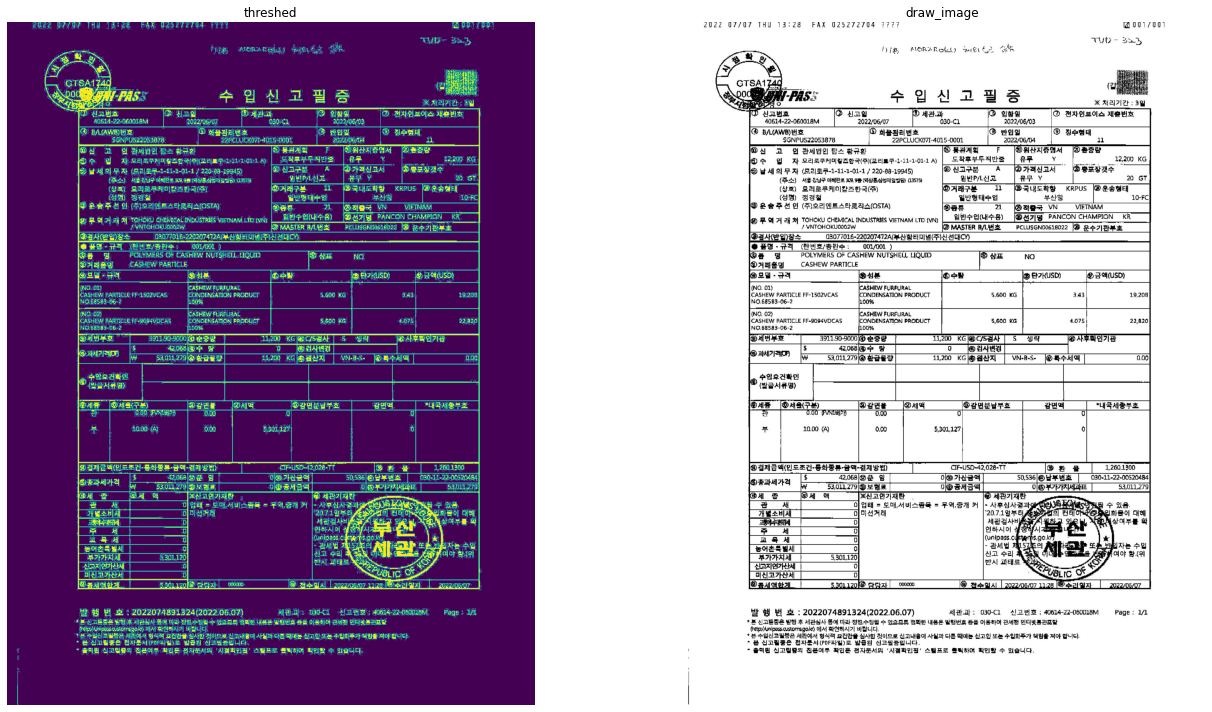

In [7]:
def edge_detection(image_bgr):
    """
    흰색바탕의 A4크기의 배경에서 운전면허증 외곽 인식
    Input : image --> 이미지(bgr image)
    return : rot_rect --> 4개의 사각형 좌표와 기운 정도를 나타내는 각도 정보
    """

    ## (1) 이미지 이진화, 흰색부분을 검은색으로 면허증 부분은 흰색으로
    draw_image = image_bgr.copy()
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    binary = cv2.bitwise_not(gray)
    th, threshed = cv2.threshold(binary, 10, 255, cv2.THRESH_BINARY)

    ## (2) Find the max-area contour
    # (_, contours,_) = cv2.findContours(threshed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    (contours,_) = cv2.findContours(threshed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 면적이 큰거 5개만 추출
    contours = sorted(contours, key = cv2.contourArea, reverse = True)[:2]

    screenCnt = None
    for index,c in enumerate(contours):
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        if len(approx) == 4:
            print("contour index==", index)
            screenCnt = approx
            ## This will extract the rotated rect from the contour
            rot_rect = cv2.minAreaRect(screenCnt)
            break

    if screenCnt is None:
        print("Do not find rectangle contour")
        rot_rect = None
    else:
        # show the contour (outline) of the piece of paper
        print ("Find rectangle contour")
        cv2.drawContours(draw_image, [screenCnt], -1, (0, 255, 0), 5)
   

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(threshed)
    plt.title("threshed")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(draw_image)
    plt.title("draw_image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # return rot_rect

image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
edge_detection(image_bgr)

좌표: [[[ 113 1833]]

 [[ 113   85]]

 [[1530   85]]

 [[1530 1833]]]


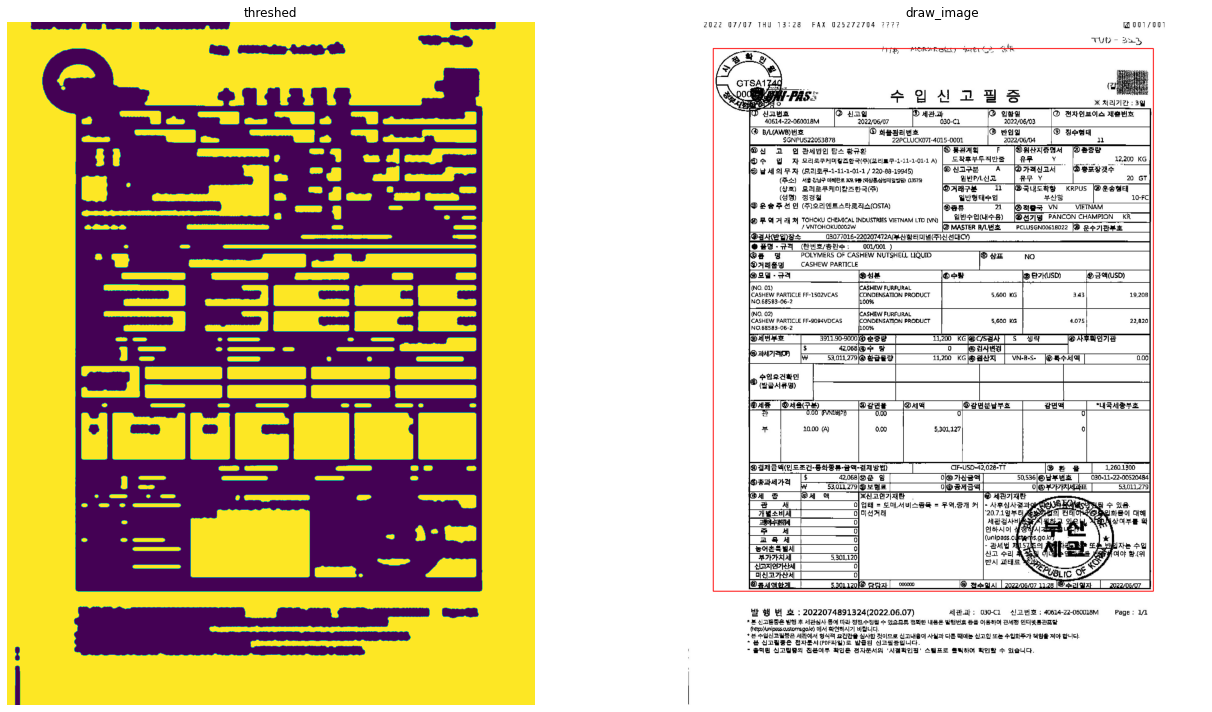

In [65]:
img = cv2.imread(image_path)
draw_image = img.copy()

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# invGamma = 1.0 / 0.3
# table = np.array([((i / 255.0) ** invGamma) * 255
#                   for i in np.arange(0, 256)]).astype("uint8")

# # apply gamma correction using the lookup table
# gray = cv2.LUT(gray, table)


ret, thresh1 = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY)

kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (27, 27))
kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13))
thresh1 = cv2.morphologyEx(thresh1, cv2.MORPH_ERODE, kernel1)
thresh1 = cv2.morphologyEx(thresh1, cv2.MORPH_DILATE, kernel2)

# find all contours
contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_LIST, 
                                       cv2.CHAIN_APPROX_SIMPLE)
# Find the largest ('max' using the key of the contour area)
biggest_contour = max(contours, key=cv2.contourArea)
sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)
largest_item= sorted_contours[1]

# Calculate the minimum enclosing rectangle: format ((x, y), (length, width), angle)
# rectangle = cv2.minAreaRect(biggest_contour)
rectangle = cv2.minAreaRect(largest_item)

# conver the minAreaRect output to points
pts = cv2.boxPoints(rectangle)
# contours must be of shape (n, 1, 2) and dtype integer
pts = pts.reshape(-1, 1, 2)
pts = pts.astype(int)

# draw contours and display
cv2.drawContours(draw_image, [pts], -1, (255, 0, 0), 2)
print("좌표:",pts)
# cv2.drawContours(draw_image, [hull], 0, (0, 255, 0), 3)

# copyImg = img.copy()
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(thresh1)
plt.title("threshed")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(draw_image)
plt.title("draw_image")
plt.axis('off')

plt.tight_layout()
plt.show()
# cv2.imwrite(os.path.join('path_to_save', imageName),
#             cv2.drawContours(img, [hull], 0, (0, 255, 0), 3))

/tmp/ipykernel_4202/1498317284.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  imgFloat = img.astype(np.float) / 255.


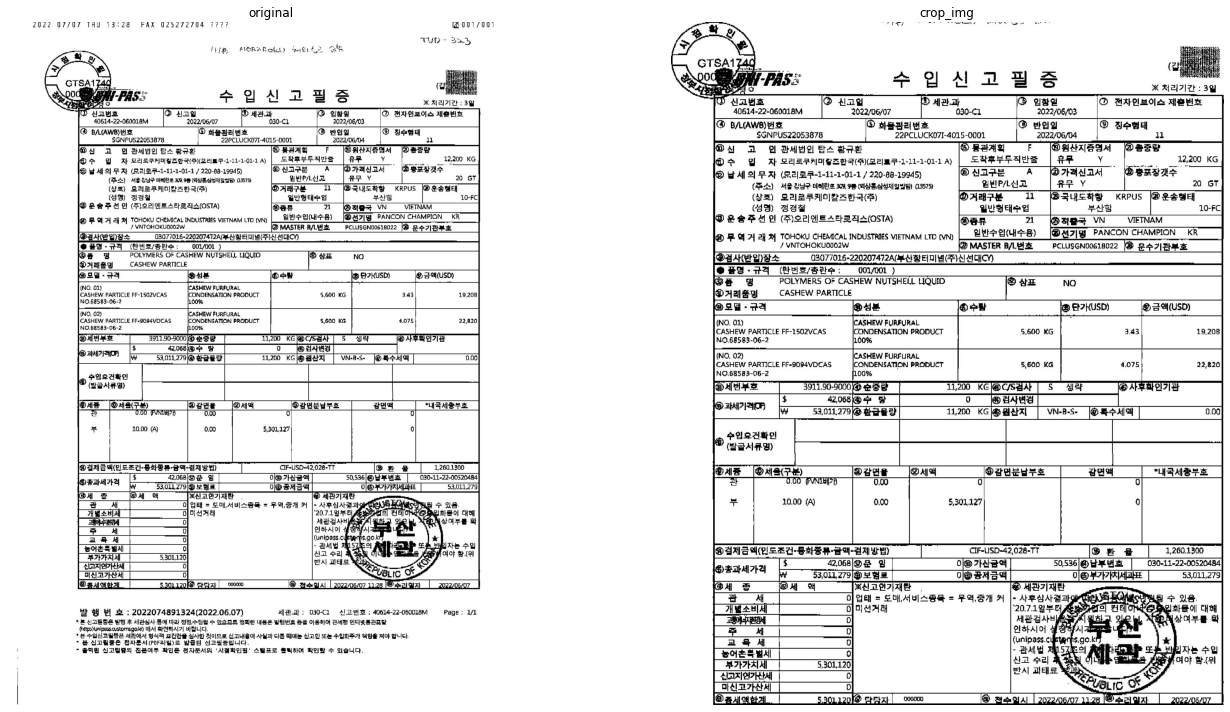

In [66]:
def areaFilter(minArea, inputImage):
    # Perform an area filter on the binary blobs:
    componentsNumber, labeledImage, componentStats, componentCentroids = \
        cv2.connectedComponentsWithStats(inputImage, connectivity=4)

    # Get the indices/labels of the remaining components based on the area stat
    # (skip the background component at index 0)
    remainingComponentLabels = [i for i in range(1, componentsNumber) if componentStats[i][4] >= minArea]

    # Filter the labeled pixels based on the remaining labels,
    # assign pixel intensity to 255 (uint8) for the remaining pixels
    filteredImage = np.where(np.isin(labeledImage, remainingComponentLabels) == True, 255, 0).astype('uint8')

    return filteredImage

# read image
img = cv2.imread(image_path)
draw_image = img.copy()

# Convert to float and divide by 255:
imgFloat = img.astype(np.float) / 255.

# Calculate channel K:
kChannel = 1 - np.max(imgFloat, axis=2)

# Convert back to uint 8:
kChannel = (255 * kChannel).astype(np.uint8)

# Threshold image:
binaryThresh = 190
_, binaryImage = cv2.threshold(kChannel, binaryThresh, 255, cv2.THRESH_BINARY)

# Filter small blobs:
minArea = 100
binaryImage = areaFilter(minArea, binaryImage)

contours, _ = cv2.findContours(binaryImage.copy(),
                           cv2.RETR_EXTERNAL,
                           cv2.CHAIN_APPROX_SIMPLE)
if len(contours) > 0:
    red_area = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(red_area)
    cv2.rectangle(draw_image,(x, y),(x+w, y+h),(0, 0, 255), 2)

crop_img = img[y:y+h, x:x+w]
cv2.imwrite('../output/수입면장-FAX-img0-crop.jpg',crop_img)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("original")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(crop_img)
plt.title("crop_img")
plt.axis('off')

plt.tight_layout()
plt.show()

In [67]:
custom_config = r'-l kor+eng --psm 6'
pytesseract.image_to_string(crop_img, config=custom_config)

'ewe    = ~ 가 0 ~\nLe 화 8\n뽀                                                                                            ine\ncr,     소입신고필증     에\n0008  er     be                                      =                    PRES erea ae\nSen PAS:           수입신고필증            ※ 처리기간 : aq\n10 신고번호         @ ane         (2 세관.과        9 임참일      @ 전자민보이스 제출번호\n40614-22-060018M          2022/06/07              030-C1            2022/06/03\n@ BALA) He                  @ 화물핀리번호                   e sea, 은  Bese El\nSGNPUSZ2053878               22PCLUCKO7I-4015-0001           2022/06/04                 u\nOA D민 관세법인 탑스 황규환                   065 봉관계획     F    때 원산지증명서 (총중량\n인 수 일 자 모리로쿠케미랄즈한국(주)(모리로쿠-1-11-1-01-1 4) ㅣ 도착푸부두직반줌 ㅣ 휴무     7 |  . 1220 6\neB 날 세 의 무 자 (무리로쿠-1-11--01-1 / 220-88-19945)            Pea fo 가력신고서 RBA\n(주소) MB 감남구 테테란로 309.9롱 (덕삼톰,삼낭제말빌됨) 0357다          월반신고      유무                       20 67\n(삼호) 모리로쿠케미칼즈한국(주)                  2거래구분     11 @SuSss KRPUS |@문송행태\n(섬명) 점경철      

In [61]:
custom_config = r'-l kor+eng --psm 6'
pytesseract.image_to_string(binaryImage, config=custom_config)

"LF\non 확 ㅇ\ni)                                                       ae\n내                                                                                                                                          bag fe\n아우스                                              aD\n12. TS                    “~ Oo           프 즈                 다아시\nNe           수 입신고필증           '\niT ae                                                   일\n4\n거여 두발   Pad           ies  a or Tay\nen   g2   |          다 ii\n마사이             a a ea\n5   Pe et ec        원본        내                   6\n0 두         eer     Cre et     Gres Tz)\nd3 ad                  ee\n아구 77000 가여\nOL eEE.       eT   M   oe ke)\nw            97957 eS\n@겸사 보일 잠            0   부 할 년     50)\n타이어 그니     aa\nae                Tl\nor am | 78 [| l@aamet\n       ee ——C—C—“‘“ Ne 거9| 0 00000 |\na Reㄴ‥\n- ee a\nEC er a   eave loxy Sato =\nBEE eee    = (ce |\nON ee\nin ST | Se 6998888960\noy = @a |x 0 ae           @저관 재트\neC 도   가    [대들 Ae Seo

In [54]:
from easyocr import Reader

langs = ['ko', 'en']
 
print("[INFO] OCR'ing input image...")
reader = Reader(lang_list=langs, gpu=False)
results = reader.readtext(binaryImage)

Using CPU. Note: This module is much faster with a GPU.


[INFO] OCR'ing input image...


/home/codev/Dev/ocr-service/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
/home/codev/Dev/ocr-service/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/codev/Dev/ocr-service/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [57]:
simple_results = reader.readtext(binaryImage, detail = 0)
simple_results

['35',
 '구',
 'GTSA',
 '744',
 'DDU',
 '7 P움',
 '수 입 신 고 필 증',
 '벼',
 '고법초',
 '소고미',
 'p) 서   과',
 '입합민',
 '0 저 모보',
 '저녁보소',
 'M',
 '4',
 'AWB 번호',
 '호 습집_ 번호',
 '보 입원',
 '점수럽태',
 'A',
 '신',
 '고',
 '민 관',
 '법원',
 '합규촌',
 '돕관계회',
 '[훨월',
 '임',
 '[오0) 손돈립',
 '수',
 '미',
 '모',
 '로',
 '다 반 주 보 1',
 '화구',
 '죄 꿀',
 '유구',
 '나서   무 5 로구',
 '고구',
 '퍽 고',
 '불포잡 _',
 '주',
 '꿈 남   베',
 'a3 3금 더돌금밥',
 '화 덥 (3',
 '민보',
 '유',
 '국',
 '모',
 '로구러',
 ' 본국주',
 '거래구문',
 '국국내도하밥',
 '속 문습범태',
 '님럼',
 '점',
 '',
 '리 턱 @수입',
 '표# 주서 P',
 '모',
 '무   묶죄 0',
 '좀썰',
 '거',
 '3 접우국',
 'V N M',
 '구떠거래처',
 '벼',
 'M',
 '민보 수입 내수껍',
 '[선 면   N',
 'M',
 'W',
 'MAS ER E번소',
 '관수구로',
 "'권사 보미 잠",
 '2   부 탑   법',
 '대)',
 '표{   규격   e 로 M랍수',
 'AD',
 '표   면',
 'M',
 'A   W N',
 'LQ',
 'D',
 '삼표',
 'Na',
 '거래훈면',
 'W   F',
 '모데   규칙',
 ') 심#',
 '수십',
 '혼y도   U D',
 '댁 USD',
 'H W',
 'W',
 'N',
 '96',
 'H W',
 'RA',
 'W',
 'n',
 '템세버구로',
 '5 운출탑',
 'U',
 '[센디 권 ',
 '심락',
 '[5 |꾸라민 (관',
 '묘무 탑',
 '[표) =사변경',
 '넷과',
 '메5',
 '#',


In [68]:
simple_results = reader.readtext(crop_img, detail = 0)
simple_results

['GT3A1744',
 'DDC',
 'T-P5요"',
 '수 입 신 고 필 증',
 "' 처리기간 : 3미",
 '신고번초',
 '신고미',
 '세관 과',
 '입합인',
 '전차민보이스 제부번호',
 '40614-22-UBUUlBM',
 '2022/05/07',
 '430-C1',
 '2422/06/대국',
 '비L(AWB)번호',
 '화율관리번호',
 '반미원',
 '집수럽태',
 'SGNPU522D5387B',
 '22PCLUCKU7I-4015-DOD1',
 'zDzz/DG/4',
 '11',
 '신',
 '고',
 '민 관세법민 탑스 합규환',
 '락관계회',
 '[원산지동버서',
 '[권) }중탑',
 '수',
 '미',
 "자 모리로쿠'미라즈란국(루)(보리-루-1-21-1-01-1 A)",
 '도얻주부두직반꿀',
 '유무',
 '12,200',
 'KG',
 '나 세 의 무 자 (정리로로-1-11-1-01-1 / 230-dd-19145)',
 '신고구분',
 '[굶가퍼신고서',
 'j3 급포잡껏수',
 '(주소)',
 '서문 감남구 테메라도 33 모금 (더돌끔버보제화k터} (135751',
 '밑반P L신고',
 '유무',
 '20',
 'GT',
 '(삼로)',
 '모리사쿠페미간주반국(주)',
 '[@거래구하',
 '11',
 '[인국내도8다',
 'KRPUs',
 '[ 문습버태',
 '(섬럼)',
 '점경수',
 '리반월태수입',
 '부산n',
 '10-FC',
 '표습 주 선 민 (주)오리멘프스타루스(OSTA)',
 '@8부',
 '거',
 '{려축국',
 'VN',
 'VIETNAM',
 '무려거래처 TOHOKU CHEMICAL INUUSTHIEs VETNAM LTD (VN)',
 '민반수입(내수용)',
 '-선기면',
 'PANCON CHAMPION',
 'KR',
 '1 VNTOHOkUGUUZW',
 'MASTER BL번소',
 'PELUs디NUDE1ED22',
 '문수기관부출',
 'D중사(반이감소',
 '[a077016-220247